## Predicting the 2019 NBA All-Stars

This notebook looks at predicting the 2019 NBA All-Stars, based on historical stats and All-Star selections. I'm not going to do a ton of Exploratory Data Analysis or feature engineering, because I'm pretty familiar with basketball stats in general, but I will provide some explanations along the way.

The end result will be a classification model that I'll use on the current season (2018-2019) stats dataset to predict the probability of All-Star selection.

Tableau Link: https://public.tableau.com/profile/stephen.pelkofer#!/vizhome/NBAAll-StarPredictor-2019/2019NBAAll-StarPredictor


In [30]:
#importing all the libraries needed
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.ensemble import RandomForestClassifier # for random forest classifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import statsmodels.api as sm
import random
from sklearn import metrics # for the check the error and accuracy of the model
import warnings
import xgboost as xgb
from xgboost import XGBClassifier
import shap
import matplotlib.pyplot as plt
import seaborn as sns #interactive plot
%matplotlib inline
warnings.filterwarnings(action='once')

C:\Users\Spelk\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
path = r'C:\Users\Spelk\Desktop\Georgia Tech Analytics\Stephen Data Science\Data Portfolio\Machine Learning\2019_All_Star_Model\new_player_data.xlsx'
df = pd.read_excel(path,sheet_name='dataframe')

Here is a preview of the data I'll be using. I have 32 columns, and over 1000 rows of player data. I pulled the stats from NBA.com and went back to the 2012-2013 season. I only pulled the top 150 scorers from each year (which contained every single All-Star). The reason I only pull the top 150 is because each season could have 500 players. If there are only 24 All-Stars, that's less than 5% of players. In other words, I could predict "No" every single time, and end up with an accuracy of 95%. 24/150 gives me a baseline of 84% accuracy (predicting "No" on all 150). If I can't build a model that has better than 84% accuracy, the model is not very useful.

In [3]:
df.head()

,Player ID,PLAYER,TEAM,AGE,GP,WIN_P,MIN,PTS,FGM,FGA,...,STL,BLK,PF,FP,DD2,TD3,+/-,Season,Eastern Conference,All Star IND
0,1,James Harden,HOU,28,50,0.800000,35.8,31.3,9.3,20.8,...,1.8,0.7,2.4,54.1,22,3,7.4,2017-2018,0,1
1,2,Giannis Antetokounmpo,MIL,23,53,0.566038,37.0,27.8,10.2,18.9,...,1.4,1.3,3.0,52.9,28,1,3.3,2017-2018,1,1
2,3,Anthony Davis,NOP,25,51,0.549020,36.4,27.4,10.0,18.6,...,1.3,2.1,2.0,52.2,32,0,2.6,2017-2018,0,1
3,4,Stephen Curry,GSW,30,43,0.767442,32.9,26.6,8.4,17.2,...,1.6,0.1,2.3,44.5,4,0,9.0,2017-2018,0,1
4,5,LeBron James,CLE,33,56,0.607143,37.0,26.5,10.2,18.7,...,1.5,1.0,1.6,52.9,32,10,-0.1,2017-2018,1,1


# Variable Selection
I have 32 columns, but I'm going ot cut this down. There are more sofisticated ways to do this, but I'll select variables/stats that make the most sense to me, and then male a correlation plot to see if I should eliminate any varables. Here are the ones I'm selecting initially.

In [4]:
collist = df.columns.tolist()
pred_vars = df[['WIN_P','MIN','PTS','FGA','FG_P','3PA','3P_P','FTA',
                'FT_P','REB','AST','TOV','STL','BLK','+/-','Eastern Conference','All Star IND']]

In [5]:
pred_vars.head()

,WIN_P,MIN,PTS,FGA,FG_P,3PA,3P_P,FTA,FT_P,REB,AST,TOV,STL,BLK,+/-,Eastern Conference,All Star IND
0,0.800000,35.8,31.3,20.8,44.8,10.7,38.4,9.9,86.5,5.1,9.0,4.2,1.8,0.7,7.4,0,1
1,0.566038,37.0,27.8,18.9,54.0,1.8,29.0,9.1,75.3,10.4,4.8,2.8,1.4,1.3,3.3,1,1
2,0.549020,36.4,27.4,18.6,54.1,2.1,36.7,7.9,82.0,10.7,2.4,2.1,1.3,2.1,2.6,0,1
3,0.767442,32.9,26.6,17.2,49.0,10.0,41.3,6.0,91.5,5.2,6.5,3.1,1.6,0.1,9.0,0,1
4,0.607143,37.0,26.5,18.7,54.4,4.8,36.2,6.1,73.7,8.1,8.9,4.4,1.5,1.0,-0.1,1,1


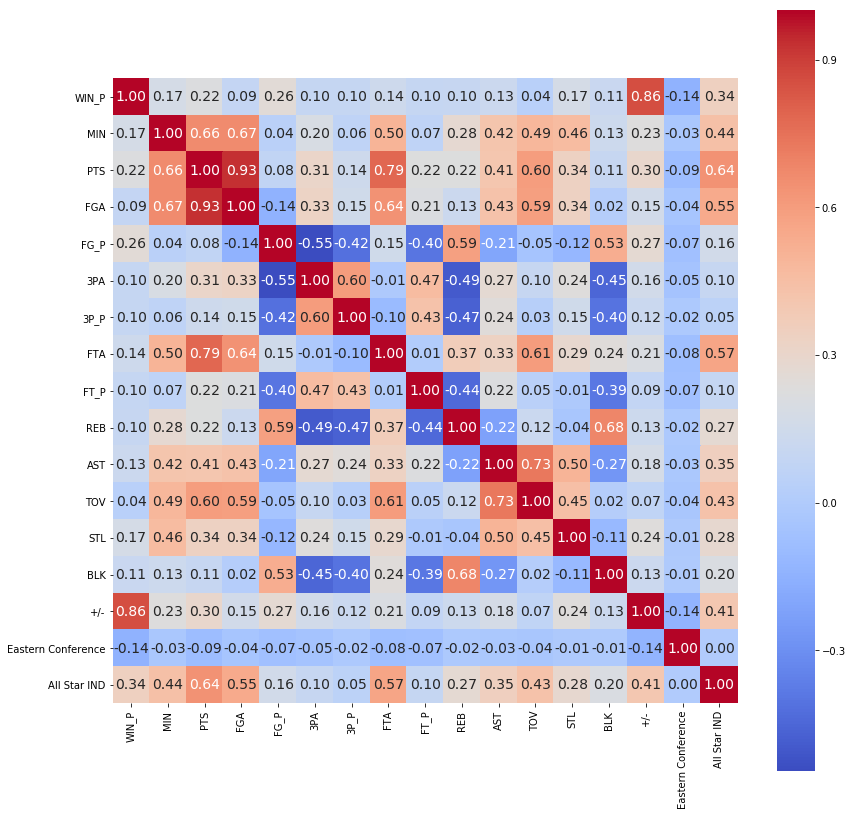

In [6]:
corr = pred_vars.corr()
plt.figure(figsize = (14,14))
sns.heatmap(corr,cbar= True, square = True, annot = True, fmt = '.2f', annot_kws = {'size':14},
            xticklabels = list(pred_vars.columns), yticklabels = list(pred_vars.columns), cmap = 'coolwarm')

The correlation plot above shows a correlation matrix between all 2-variable combinations. In the bottom row, we can see which variables correlate the most with "All Star IND." By no surpise, "Points" is what has the highest correlation (0.64). The one thing I notice in this is that "Points" and "FGA" have a .93 correlation. There's a concept called colinearity, which means that including both of these variables in the analysis could inflate the variance of the coefficient of one of the variables. Given that, I'll just keep points and delete FGA.

In [7]:
try:
    pred_vars.drop(axis = 1, labels = 'FGA',inplace=True)
except:
    pass

C:\Users\Spelk\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


The next component will be to split the dataset into a training set and a test set or validation set. This is done in most modeling so we don't overfit the model to the data. Basically, new data might not completely resemble the old data, so we use a holdout dataset to test our model on, before actually testing it on this year's data. This strategy is an attempt to limit random effect of the training data.

In [8]:
#Split data into train and test sets
random.seed(20)
train, test = train_test_split(pred_vars, test_size = 0.3)
print(train.shape)
print(test.shape)

(735, 16)
(316, 16)


In [9]:
train_X = train.drop(axis = 1, labels = 'All Star IND')
test_X = test.drop(axis = 1, labels = 'All Star IND')
train_Y = train[['All Star IND']]
test_Y = test[['All Star IND']]

## Building the Classification Model
Now the fun part, building the classification model. I'm going to use a logistic regression model, which will give probabilities as the output. I can then use a standard of >.50 for "1" (Predicted All-Star).

In [33]:
logreg = LogisticRegression()
model = logreg.fit(train_X, train_Y)

C:\Users\Spelk\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [34]:
logit_model=sm.Logit(train_Y,train_X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.211873
         Iterations 8
                          Results: Logit
Model:               Logit            Pseudo R-squared: 0.542     
Dependent Variable:  All Star IND     AIC:              341.4538  
Date:                2019-01-27 15:00 BIC:              410.4518  
No. Observations:    735              Log-Likelihood:   -155.73   
Df Model:            14               LL-Null:          -339.87   
Df Residuals:        720              LLR p-value:      5.9762e-70
Converged:           1.0000           Scale:            1.0000    
No. Iterations:      8.0000                                       
------------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------
WIN_P               2.4698   1.9754  1.2503 0.2112 -1.4019  6.3415
MIN                -0.0365   0.0540 -0.6760 0.4990 -0

In [35]:
y_pred = logreg.predict(test_X)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(test_X, test_Y)))

Accuracy of logistic regression classifier on test set: 0.94


The result of my classifier is 94% accuracy; however, some of the variables have relatively high p-values. I am going to eliminate all variables with p-values over .05 and see if I can improve my model accuracy.

In [38]:
train_X2= train_X.drop(labels = ['WIN_P','MIN','3P_P','FTA','TOV','STL'], axis = 1)
test_X2 = test_X.drop(labels = ['WIN_P','MIN','3P_P','FTA','TOV','STL'], axis = 1)

In [41]:
logit_model=sm.Logit(train_Y,train_X2)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.215293
         Iterations 8
                          Results: Logit
Model:               Logit            Pseudo R-squared: 0.534     
Dependent Variable:  All Star IND     AIC:              334.4803  
Date:                2019-01-27 15:06 BIC:              375.8792  
No. Observations:    735              Log-Likelihood:   -158.24   
Df Model:            8                LL-Null:          -339.87   
Df Residuals:        726              LLR p-value:      1.3386e-73
Converged:           1.0000           Scale:            1.0000    
No. Iterations:      8.0000                                       
------------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------
PTS                 0.4317   0.0498  8.6716 0.0000  0.3341  0.5293
FG_P               -0.1815   0.0287 -6.3342 0.0000 -0

In [43]:
logreg = LogisticRegression()
model = logreg.fit(train_X2, train_Y)
y_pred = logreg.predict(test_X2)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(test_X2, test_Y)))

C:\Users\Spelk\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of logistic regression classifier on test set: 0.94


***Accuracy***

Both models had an accuracy of 94%, but I'll stick with the second model, so I'm not bringing in unnecessary variables. 94% is pretty good, considering some of the incorrect predictions could be from injuries, being in a tougher conference, or players getting selected because the game is in their team's city (should've made this a variable).

Here is a graph that shows the importance/impact of each variable on the model output. This is a function from the SHAP package. In simple terms, SHAP (SHapley Additive exPlanations) is a unified approach to explain the output of any machine learning model. SHAP values represent a feature's responsibility for a change in the model output.

The plot below shows the SHAP magnitude across all examples in the traning data. The color represents the variable value (red high, blue low). For example, high PTS pushes the model output (probability) higher. And low PTS pushes the output lower. PTS, +/-, and AST appear to be the most influential predictors in the model.

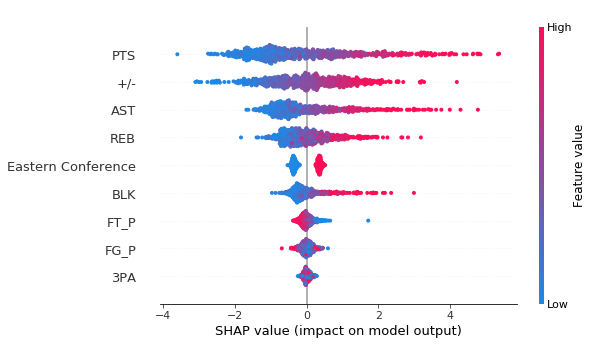

In [51]:
# summarize the effects of all the features
explainer = shap.LinearExplainer(model, train_X2)
shap_values = explainer.shap_values(train_X2)
shap.summary_plot(shap_values, train_X2)

I can actually look at individual observations with the shap package as well, which is a really cool feature. I'm going to look at Giannis Antetokounmpo during last year's season.

In [59]:
train_shap = train_X2.merge(df,how='left', left_index=True, right_index=True)
train_shap = train_shap[['PLAYER','TEAM','Season','PTS_x','All Star IND']]
sorted_shap = train_shap.sort_values(by = ['PTS_x'], ascending=False)
sorted_shap.head(10)

,PLAYER,TEAM,Season,PTS_x,All Star IND
0,James Harden,HOU,2017-2018,31.3,1
151,Russell Westbrook,OKC,2016-2017,31.1,1
153,James Harden,HOU,2016-2017,29.2,1
752,Carmelo Anthony,NYK,2012-2013,28.6,1
901,Kobe Bryant,LAL,2011-2012,28.4,1
902,Kevin Durant,OKC,2011-2012,27.9,1
1,Giannis Antetokounmpo,MIL,2017-2018,27.8,1
154,DeMarcus Cousins,NOP,2016-2017,27.8,1
155,Anthony Davis,NOP,2016-2017,27.7,1
303,Kevin Durant,OKC,2015-2016,27.7,1


In [60]:
shap.force_plot(explainer.expected_value, shap_values[1,:], train_X2.loc[1,:])

The plot above shows that BLK and Eastern Conference were the only variables that brought his predicted output down last year. This is confusing and it doesn't mean those were necessarily bad things, but given the rest of his stats, those are what brought the output down.

I'll now add the predictions to my test set to see which predictions were wrong.

In [61]:
test['Prediction']=preds
test_preds = test.merge(df,how='left', left_index=True, right_index=True)

C:\Users\Spelk\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [62]:
test_preds = test_preds[['PLAYER','TEAM','Season','All Star IND_y','Prediction']]
test_preds['Accuracy'] = test_preds['All Star IND_y']==test_preds['Prediction']
test_preds.head(30)

,PLAYER,TEAM,Season,All Star IND_y,Prediction,Accuracy
960,MarShon Brooks,NJN,2011-2012,0,0,True
285,Marcus Smart,BOS,2016-2017,0,0,True
531,Nick Young,LAL,2014-2015,0,0,True
744,Chris Kaman,LAL,2013-2014,0,0,True
207,Dion Waiters,MIA,2016-2017,0,0,True
912,Carmelo Anthony,NYK,2011-2012,1,1,True
564,Jodie Meeks,DET,2014-2015,0,0,True
177,Eric Bledsoe,PHX,2016-2017,0,1,False
421,Elfrid Payton,ORL,2015-2016,0,0,True
824,Evan Turner,PHI,2012-2013,0,0,True


The above code made a True/False column for predictions. Here were all of the incorrect predictions sorted by year.

In [63]:
false_preds = test_preds.loc[test_preds['Accuracy'] == False]
false_preds.sort_values(by = ['Season'], ascending=False)

,PLAYER,TEAM,Season,All Star IND_y,Prediction,Accuracy
21,Blake Griffin,DET,2017-2018,0,1,False
136,Draymond Green,GSW,2017-2018,1,0,False
24,Klay Thompson,GSW,2017-2018,1,0,False
177,Eric Bledsoe,PHX,2016-2017,0,1,False
196,LaMarcus Aldridge,SAS,2016-2017,0,1,False
329,Chris Bosh,MIA,2015-2016,1,0,False
341,Pau Gasol,CHI,2015-2016,1,0,False
331,Dwyane Wade,MIA,2015-2016,1,0,False
323,John Wall,WAS,2015-2016,1,0,False
342,Andre Drummond,DET,2015-2016,1,0,False


In [67]:
This_Year = pd.read_excel(path,sheet_name='This_Season')
pred_vars2 = This_Year[['PTS','FG_P','3PA','FT_P','REB','AST','BLK','+/-','Eastern Conference']]


The last step in this notebook will be to predict this year's All-Stars with my model. After that, I'll use Tableau to vizualize who should be playing in Atlanta this year, and who got in based on popularity.

In [68]:
preds_proba2 = model.predict_proba(pred_vars2)
df_prob = []
for i in preds_proba2:
    df_prob.append(i[1])
This_Year['Pred_Prob'] = df_prob
This_Year.head(10)

,Player ID,PLAYER,TEAM,AGE,GP,WIN_P,MIN,PTS,FGM,FGA,...,STL,BLK,PF,FP,DD2,TD3,+/-,Season,Eastern Conference,Pred_Prob
0,1,James Harden,HOU,29,45,0.600000,37.4,36.2,10.5,23.9,...,2.1,0.7,3.4,59.0,19,6,2.3,2018-2019,0,0.995067
1,2,Stephen Curry,GSW,30,38,0.789474,34.4,29.3,9.8,19.9,...,1.2,0.4,2.6,45.4,2,0,10.6,2018-2019,0,0.944861
2,3,Anthony Davis,NOP,25,41,0.487805,37.1,29.3,10.5,20.6,...,1.7,2.6,2.6,62.6,32,0,3.4,2018-2019,0,0.997112
3,4,Kevin Durant,GSW,30,49,0.714286,35.6,27.9,9.7,19.0,...,0.8,1.2,1.9,48.3,13,2,8.9,2018-2019,0,0.988524
4,5,Kawhi Leonard,TOR,27,37,0.675676,35.1,27.8,9.7,19.1,...,1.9,0.5,1.5,47.3,11,0,5.1,2018-2019,1,0.956946
5,6,LeBron James,LAL,34,34,0.588235,34.7,27.3,10.0,19.3,...,1.3,0.7,1.6,50.6,17,3,2.8,2018-2019,0,0.957694
6,7,Joel Embiid,PHI,24,46,0.673913,33.5,27.2,9.1,18.5,...,0.6,2.0,3.3,52.6,40,1,5.9,2018-2019,1,0.997509
7,8,Paul George,OKC,28,47,0.617021,35.9,26.9,9.0,20.3,...,2.3,0.5,2.7,48.4,15,0,7.6,2018-2019,0,0.944459
8,9,Giannis Antetokounmpo,MIL,24,44,0.750000,33.2,26.6,9.9,17.0,...,1.4,1.5,3.4,55.1,33,4,8.8,2018-2019,1,0.998282
9,10,Blake Griffin,DET,29,46,0.456522,36.3,26.5,9.0,18.6,...,0.8,0.5,2.8,44.1,16,1,-0.9,2018-2019,1,0.849154


In [70]:
This_Year[['PLAYER','TEAM','Season','Pred_Prob']].sort_values(by = 'Pred_Prob', ascending = False).head(30)

,PLAYER,TEAM,Season,Pred_Prob
8,Giannis Antetokounmpo,MIL,2018-2019,0.998282
6,Joel Embiid,PHI,2018-2019,0.997509
2,Anthony Davis,NOP,2018-2019,0.997112
18,Russell Westbrook,OKC,2018-2019,0.995938
0,James Harden,HOU,2018-2019,0.995067
3,Kevin Durant,GSW,2018-2019,0.988524
5,LeBron James,LAL,2018-2019,0.957694
4,Kawhi Leonard,TOR,2018-2019,0.956946
1,Stephen Curry,GSW,2018-2019,0.944861
7,Paul George,OKC,2018-2019,0.944459


In [71]:
path2 = r'C:\Users\Spelk\Desktop\Georgia Tech Analytics\Stephen Data Science\Data Portfolio\Machine Learning\2019_All_Star_Model\2019_Preds.csv'
#Extract the File
This_Year.to_csv(path2, index = False)

Tableau Link: https://public.tableau.com/profile/stephen.pelkofer#!/vizhome/NBAAll-StarPredictor-2019/2019NBAAll-StarPredictor     